Inprocessing refers to mitigating the bias in model's predictions during training.
In-processing techniques have several advantages over pre-processing techniques. They can be more effective at addressing bias that is deeply embedded in the data, and they do not require any modifications to the data collection or preprocessing pipeline

Given the fact that our baseline model was baised against specific gender and race, using prejudice remover should help us get better fairness

In [17]:
import aif360
import holisticai
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from holisticai.bias.mitigation import PrejudiceRemover

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

from holisticai.bias.metrics import classification_bias_metrics

Data Gathering

In [4]:
# baseline_preprocessed_df = pd.read_csv("C:/Users/athar/OneDrive/Desktop/Rutgers/Ethical Stat Learning/Project/data/data_preprocessed_baseline.csv",index_col=0)
# baseline_preprocessed_df = baseline_preprocessed_df.drop(['id','age_cat'],axis=1)

In [3]:
baseline_preprocessed_df = pd.read_csv("../../data/data_baseline.csv",index_col=0)
baseline_preprocessed_df = baseline_preprocessed_df.drop(['Asian_race','Hispanic_race','Other_race','High_score_text','High_v_score_text','Low_score_text','Native American_race'],axis=1)

In [4]:
protected_variables = ["sex", "African-American_race"]
output_variable = ["two_year_recid"]

In [5]:
# Simple preprocessing
y = baseline_preprocessed_df[output_variable]
X = pd.get_dummies(baseline_preprocessed_df.drop(output_variable, axis=1))
group = ["African-American_race"]
group_a = baseline_preprocessed_df["African-American_race"] == 1
group_b = baseline_preprocessed_df["African-American_race"] == 0
data_ = [X, y, group_a, group_b]


In [6]:
# Train test split
dataset = train_test_split(*data_, test_size=0.2, shuffle=True)
train_data = dataset[::2]
test_data = dataset[1::2]

In [7]:
# efficacy metrics from sklearn
from sklearn import metrics

# dictionnary of metrics
metrics_dict={
        "Accuracy": metrics.accuracy_score,
        "Balanced accuracy": metrics.balanced_accuracy_score,
        "Precision": metrics.precision_score,
        "Recall": metrics.recall_score,
        "F1-Score": metrics.f1_score}

# efficacy metrics dataframe helper tool
def metrics_dataframe(y_pred, y_true, metrics_dict=metrics_dict):
    metric_list = [[pf, fn(y_true, y_pred)] for pf, fn in metrics_dict.items()]
    return pd.DataFrame(metric_list, columns=["Metric", "Value"]).set_index("Metric")

In [8]:
# import
from holisticai.bias.mitigation import GridSearchReduction

<h3> GridSearchReduction

In [10]:
# data and model
X_train, y_train, group_a_train, group_b_train = train_data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
model_lr = LogisticRegression()
model_lr.fit(X_train_scaled,y_train)

c:\Users\athar\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [11]:
# initialize
gsr = GridSearchReduction(constraints="FalsePositiveRateParity")

# incorporate model in gsr
gsr.transform_estimator(model_lr)

GridSearchReduction(constraints='FalsePositiveRateParity')

In [12]:
# fit with data
gsr.fit(X_train_scaled, y_train, group_a_train, group_b_train)

GridSearchReduction(constraints='FalsePositiveRateParity')

In [13]:
# predict test
X_test, y_test, group_a_test, group_b_test = test_data
X_test_scaled = scaler.transform(X_test)
y_pred = gsr.predict(X_test_scaled)
y_proba = gsr.predict_proba(X_test_scaled)
y_score = y_proba[:,1]
y_true = y_test

In [ ]:
test_df = X_test.copy()
test_df['y_test'] = y_test

In [93]:
# Baseline efficacy
metrics_dataframe(y_pred, y_true)

,Value
Metric,
Accuracy,0.704941
Balanced accuracy,0.694596
Precision,0.714286
Recall,0.582822
F1-Score,0.641892


In [14]:
# bias
# holisticai imports
classification_bias_metrics(group_a_test, group_b_test, y_pred, y_true, metric_type='both')

,Value,Reference
Metric,,
Statistical Parity,0.221795,0
Disparate Impact,1.820521,1
Four Fifths Rule,0.549293,1
Cohen D,0.467467,0
2SD Rule,8.614151,0
Equality of Opportunity Difference,0.219186,0
False Positive Rate Difference,0.133344,0
Average Odds Difference,0.176265,0
Accuracy Difference,-0.000148,0


Not very fair

In [15]:
test_df = X_test.copy()
test_df['y_test'] = y_test
test_df['y_pred_gsr'] = y_pred
test_df['y_score_gsr'] = y_score

<AxesSubplot:xlabel='y_score_gsr', ylabel='Density'>

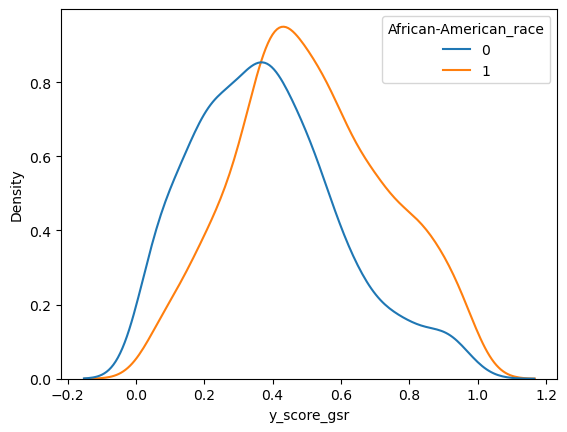

In [18]:
sns.kdeplot(data=test_df, x = 'y_score_gsr', hue='African-American_race')

*note :  for some reason, showing no change in performance

<b>prejudice remover

Prejudice remover works by adding a regularization term to the model's loss function. This regularization term penalizes the model for making predictions that are inconsistent with the desired fairness criteria.

In [22]:
model_lr2 = LogisticRegression()
model_lr2.fit(X=X_train_scaled,y=y_train)
print(model_lr2.coef_)


11
[[ 0.09898977 -0.52888233  0.08888766 -0.00543469  0.08752142  0.59726861
   0.7430724   0.08855446  0.16196245  0.03173834 -0.15490809]]
[-0.25368201]


c:\Users\athar\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
pr2 = PrejudiceRemover(eta=1,C=0.5,init_type='StandarLR')
pr2.transform_estimator()

PrejudiceRemover(C=0.5, eta=1, init_type='StandarLR')

In [24]:
pr2.fit( X=X_train_scaled, y_true=y_train, group_a=group_a_train, group_b=group_b_train)

PrejudiceRemover(C=0.5, eta=1, init_type='StandarLR')

In [25]:
# predict test
y_pred = pr2.predict(X_test_scaled,group_a=group_a_test,group_b=group_b_test)
y_proba = pr2.predict_proba(X_test_scaled,group_a=group_a_test,group_b=group_b_test)
y_score = y_proba[:,1]
y_true = y_test

In [26]:
# Baseline efficacy
metrics_dataframe(y_pred, y_true)

,Value
Metric,
Accuracy,0.694502
Balanced accuracy,0.686252
Precision,0.715631
Recall,0.568862
F1-Score,0.633862


In [27]:
# bias
# holisticai imports
from holisticai.bias.metrics import classification_bias_metrics
classification_bias_metrics(group_a_test, group_b_test, y_pred, y_true, metric_type='both')

,Value,Reference
Metric,,
Statistical Parity,0.131727,0
Disparate Impact,1.439305,1
Four Fifths Rule,0.694780,1
Cohen D,0.275477,0
2SD Rule,5.164067,0
Equality of Opportunity Difference,0.120675,0
False Positive Rate Difference,0.050714,0
Average Odds Difference,0.085695,0
Accuracy Difference,-0.005088,0


In [30]:
test_df['y_pred_pr'] = y_pred
test_df['y_score_pr'] = y_score


<AxesSubplot:xlabel='y_score_pr', ylabel='Density'>

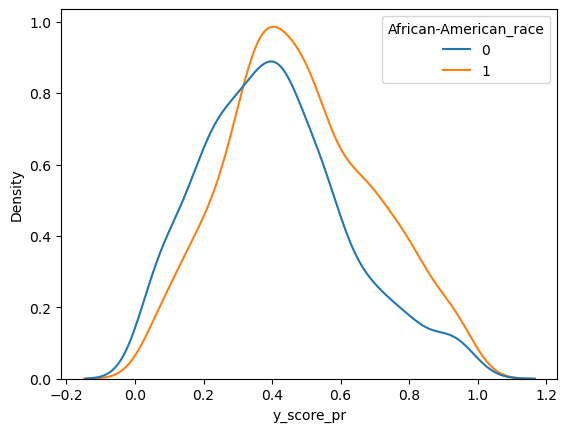

In [31]:
sns.kdeplot(data=test_df, x = 'y_score_pr', hue='African-American_race')

Distribution has gotten fairer